In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import re
import nltk
import math
import os
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import sklearn.metrics
from sklearn.metrics import confusion_matrix

%matplotlib inline


##   Classification 

## Read the data

In [2]:
#proteins.to_csv('proteins-locations-7.csv',index = None)

df_hug = pd.read_csv('proteins-locations-7.csv')

df_hug.head()

,name,sequence,location,label
0,sp|Q8C7V3|UTP15_MOUSE,MAGYKPVAIQTYPVLGEKITQDTLYWNNYKTPVQIKEFGAVSKVDF...,7,nucleus
1,sp|Q9S773|MYB97_ARATH,MIVYGGGASEDGEGGGVVLKKGPWTVAEDETLAAYVREYGEGNWNS...,7,nucleus
2,sp|Q21WJ4|RBFA_RHOFT,MRKKSKTPNRAFKVADQIQRDLTELIARELKDPRVGMVTIQAVEVT...,3,cytoplasm
3,sp|Q10MW6|DJC27_ORYSJ,MGIPVRSLLVASIVLSSIALHVAAAKNLDPYKVLGVDKSASQRDIQ...,0,ER
4,sp|P42054|VDAC_PEA,MVKGPGLYTDIGKKARDLLYKDYHSDKKFTISTYSPTGVAITSSGT...,6,mitochondria


In [3]:
df_hug.shape

(176934, 4)

## Subset the data: use ~ 10,000 rows to create a smaller dataframe

In [4]:
df_new = df_hug.sample(frac=0.06)
df_new.shape

(10616, 4)

In [5]:
df_new.columns

Index([u'name', u'sequence', u'location', u'label'], dtype='object')

## Transform the protein sequence data with CountVectorizer to get peptide frequency. Split the data into training & test sets.

In [6]:
# In this case, hexapeptide frequency is used for analysis
vect = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(6,6))
#vect = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(2,2))

In [7]:
X = vect.fit_transform(df_hug.sequence)
y = df_hug.location

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

((141547, 21560947), (141547,))
((35387, 21560947), (35387,))


In [9]:
y_test.value_counts()

0    6476
8    6090
1    5196
6    4830
9    4511
7    4392
3    3892
Name: location, dtype: int64

## Logistic Regression Model

In [10]:
%%time
# Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
#lr.predict(X_test)
print("Logistic Regression Score: {:.2f}".format(lr.score(X_test, y_test)))

/Users/scottlew/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/scottlew/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/scottlew/anaconda2/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logistic Regression Score: 0.85
CPU times: user 2h 48min 29s, sys: 2min 57s, total: 2h 51min 26s
Wall time: 3h 58min


In [11]:
# Generate Confusion Matrix for Logistic Regression
actual = y_test
predictions = lr.predict(X_test)
print('Confusion Matrix for Logistic Regression Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Logistic Regression Model
()
[[5853  184    8   87  274   15   55]
 [ 113 4827    1   18  213   17    7]
 [  14    1 2873  122  776   14   92]
 [  63    7   90 3663  826   33  148]
 [  12    4  153  146 3933   20  124]
 [  14   17    2   46  236 5724   51]
 [  33    6   92  154  811   51 3364]]


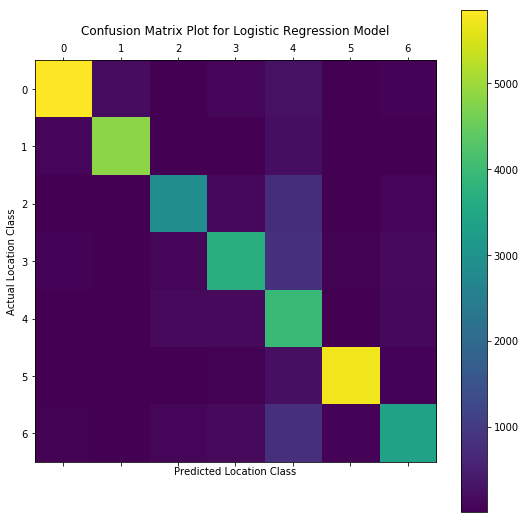

In [20]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow

plt.figure(figsize=(9,9))
plt.matshow(cm, fignum=1)
plt.title('Confusion Matrix Plot for Logistic Regression Model')
plt.colorbar()
plt.xlabel('Predicted Location Class')
plt.ylabel('Actual Location Class')

plt.show()

## 85% accuracy with hexapeptide count

In [18]:
from sklearn.metrics import classification_report

log_reg_prediction = lr.predict(X_test)
print(classification_report(log_reg_prediction, y_test))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      6102
           1       0.93      0.96      0.94      5046
           3       0.74      0.89      0.81      3219
           6       0.76      0.86      0.81      4236
           7       0.90      0.56      0.69      7069
           8       0.94      0.97      0.96      5874
           9       0.75      0.88      0.81      3841

   micro avg       0.85      0.85      0.85     35387
   macro avg       0.84      0.87      0.85     35387
weighted avg       0.86      0.85      0.85     35387



In [13]:
import pickle

In [14]:
# Save the Modle to file in the current working directory

#Pkl_Filename = "lr_location7_pentapeptide.pkl"  

#with open(Pkl_Filename, 'wb') as file:  
    #pickle.dump(lr, file)

In [15]:
# Load the Model back from file
#with open(Pkl_Filename, 'rb') as file:  
    #Pickled_lr = pickle.load(file)

#Pickled_lr

In [16]:
# Verify the logistic regression model still works using the original test data used above
#Pickled_lr.score(X_test, y_test)